<div style="border:solid green 2px; padding: 20px">

<b>Привет, Георгий!</b>

Меня зовут Ярослав П. и я буду проверять твой проект. Попробую помочь сделать тебе его еще лучше!

Предлагаю общаться на «**ты**». Если это неприемлемо, обязательно напиши мне в комментариях — мы перейдем на «**вы**».

Ниже ты найдешь мои комментарии - пожалуйста, не перемещай, не изменяй и не удаляй их. Я буду использовать цветовую разметку:

<div class="alert alert-danger">
<b>Комментарий ревьюера:</b> Так выделены самые важные замечания. Без их отработки проект не будет принят. </div>

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b> Так выделены небольшие замечания или советы.

</div>

<div class="alert alert-success">
<b>Комментарий ревьюера:</b> Так я выделяю все остальные комментарии.</div>

Давай работать над проектом в диалоге: если ты что-то меняешь в проекте или отвечаешь на мои комменатри — пиши об этом. Мне будет легче отследить изменения, если ты выделишь свои комментарии:
<div class="alert alert-info"> <b>Комментарий студента:</b> Например, вот так.</div>

Всё это поможет выполнить повторную проверку твоего проекта оперативнее. 
    
    
### <span style="color:orange">Обратная связь</span><a class="tocSkip">

- Отлично выполненный проект!
- Молодец, что используешь функции для однотипных действий.
- Также верно применен Bootstrap и выполнены расчеты.
- Только не совсем понял логику расчета риска. Оставил комментарий.
    
### <span style="color:orange">Обратная связь (v2)</span><a class="tocSkip">

- Спасибо, что пояснил логику, прошу прощения, был неправ с возратом из-за этого. Проект отличный :)
    
Проект принят, успехов в дальнейшем обучении!

<div class="alert alert-info"> 
<b>Комментарий студента:</b> 
    
Ярослав, Привет! 
Добавил немного pretty print и пояснил по расчету риска (комментарии ниже по коду)

</div>


# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Введение хорошее.

</div>

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера</b>

Также можно добавить описание данных, с которыми предстоит работа, и оглавление.

</div>


## Предварительная подготовка

In [1]:
import pandas as pd
from IPython.display import display_html
from itertools import chain,cycle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy import stats

In [2]:
GLOBAL_RANDOM_STATE = 12345

In [3]:
# функция возвращает все данные как list из pd.DataFrame
def get_data():
    data = []
    for i in [0,1,2]:
        fpath = "/datasets/geo_data_{}.csv".format(i)
        data.append(pd.read_csv(fpath))
    return data

In [4]:
# SO-copied: отображение нескольких df рядом
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:left"><td style="vertical-align:top">'
        html_str+=f'<h3>{title}</h3>'
        html_str+=df.to_html().replace('table','table style="display: inline; "')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [5]:
# вывести графическое представление матрицы корреляций
def correlation(dfs: list, headers: list = [], figsize=(10,5), method='pearson') -> None:
    fig, axs = plt.subplots(ncols=len(dfs))
    for i in range(0, len(dfs)):
        sns.heatmap(
            ax=axs[i],
            data=dfs[i].corr(method=method), 
            annot = True, 
            vmin=-1, 
            vmax=1, 
            center= 0, 
            cmap= 'coolwarm'
        )  
        axs[i].set_xlabel(headers[i], fontsize=20)
    fig.set_size_inches(figsize)
    fig.tight_layout()

In [6]:
# разбиение на выборки 
def split(
        features: pd.DataFrame,
        target: pd.Series,
        shuffle=True,
        test_size: float = 0.25,
        random_state: int = GLOBAL_RANDOM_STATE) -> list:
    return train_test_split(
            features,
            target,
            test_size = test_size,
            random_state = random_state,
            shuffle=shuffle)

In [7]:
# масштабирование признаков
def _prescale_correction(d):
    return d.copy().reset_index(drop=True)
def scale(ufeat_train: pd.DataFrame, ufeat_valid: pd.DataFrame) -> list:
    feat_train = _prescale_correction(ufeat_train)
    feat_valid = _prescale_correction(ufeat_valid)
    scaler = StandardScaler()
    scaler.fit(feat_train[feat_train.columns])
    feat_train[feat_train.columns] = scaler.transform(feat_train[feat_train.columns])
    feat_valid[feat_train.columns] = scaler.transform(feat_valid[feat_train.columns])
    return [feat_train, feat_valid]
        

In [8]:
def split_and_scale(
        features: pd.DataFrame,
        target: pd.Series,
        shuffle=True,        
        test_size: float = 0.25) -> list:    
    ufeat_train, ufeat_valid, targ_train, targ_valid = split(features, target, shuffle, test_size)
    feat_train, feat_valid = scale(ufeat_train, ufeat_valid)
    return [feat_train, feat_valid, _prescale_correction(targ_train), _prescale_correction(targ_valid)]

In [9]:
# построение гистограм для одного и более фреймов
def hist(onecolumn_frames_list=[], xlab='', ylab='', title='', bins=10, xrange=None, figsize=(10,5), fontsize=12):
    fig, ax = plt.subplots()
    rmin, rmax = 999999999999999, 0
    series_list, legend_list = [], []
    alpha, alpha_step = 1, int((40 / len(onecolumn_frames_list))) / 100 # полная прозрачность нам не нужна 
    for i in onecolumn_frames_list:
        column_name = i.columns[0]
        legend_list.append(column_name)
        series_list.append(i[column_name])
    for i in series_list:
        rmin = i.min() if i.min() < rmin else rmin
        rmax = i.max() if i.max() > rmax else rmax
        ax.hist(i,bins=bins, alpha=alpha)
        alpha -= alpha_step
    rrange = xrange if xrange != None else (rmin,rmax)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_xlim(rrange)
    ax.legend(legend_list)
    fig.set_size_inches(figsize)
    plt.rcParams.update({'font.size': fontsize})
    plt.grid()
    fig.tight_layout()

In [10]:
# pretty-formatted миллиарды
def pretty_billions_f(number: float) -> float:
    return number / 1e9
def pretty_billions(number: float) -> str:
     return "{:.3} млрд.руб.".format(pretty_billions_f(number))

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Все функции в одном месте - удобно.

</div>


## Загрузка и подготовка данных

Посмотрим на данные:

In [11]:
data = get_data()

In [12]:
for i in range(0, len(data)):
    display_side_by_side(
        data[i].sample(8, random_state=GLOBAL_RANDOM_STATE),
        data[i].describe(),
        titles = [f'Регион №{i}: случайные 8 элементов',f'Регион №{i}: базовая статистика']
    )

Регион №0: случайные 8 элементов 
 
 
 
 id 
 f0 
 f1 
 f2 
 product 
 
 
 
 
 71751 
 7Z2gx 
 0.948970 
 -0.057547 
 2.095727 
 10.038645 
 
 
 80493 
 b2HU8 
 0.992974 
 0.206671 
 -0.142278 
 114.551489 
 
 
 2655 
 Y0dXD 
 1.199854 
 -0.563356 
 -1.852991 
 132.603635 
 
 
 53233 
 Mje59 
 0.691422 
 -0.433347 
 0.564974 
 169.072125 
 
 
 91141 
 yqXxU 
 0.420772 
 0.972638 
 0.736190 
 122.325180 
 
 
 9539 
 AUUYz 
 -0.502687 
 0.729647 
 0.510063 
 37.735331 
 
 
 8482 
 cVWy3 
 1.358998 
 -0.569837 
 5.207498 
 139.227191 
 
 
 30284 
 RUKIy 
 0.949783 
 0.187695 
 1.368214 
 72.491987 
 
 
 Регион №0: базовая статистика 
 
 
 
 f0 
 f1 
 f2 
 product 
 
 
 
 
 count 
 100000.000000 
 100000.000000 
 100000.000000 
 100000.000000 
 
 
 mean 
 0.500419 
 0.250143 
 2.502647 
 92.500000 
 
 
 std 
 0.871832 
 0.504433 
 3.248248 
 44.288691 
 
 
 min 
 -1.408605 
 -0.848218 
 -12.088328 
 0.000000 
 
 
 25% 
 -0.072580 
 -0.200881 
 0.287748 
 56.497507 
 
 
 50% 
 0.502360 
 0.250252 
 2.515969 
 91.849972 
 
 
 75% 
 1.073581 
 0.700646 
 4.715088 
 128.564089 
 
 
 max 
 2.362331 
 1.343769 
 16.003790 
 185.364347

Регион №1: случайные 8 элементов 
 
 
 
 id 
 f0 
 f1 
 f2 
 product 
 
 
 
 
 71751 
 aTbUt 
 -0.371866 
 -1.862494 
 3.002210 
 80.859783 
 
 
 80493 
 CK34V 
 9.015122 
 -13.881455 
 1.995363 
 53.906522 
 
 
 2655 
 ioXCO 
 -6.507568 
 -4.817448 
 1.003449 
 30.132364 
 
 
 53233 
 xk6tF 
 14.560845 
 -10.667755 
 1.995175 
 53.906522 
 
 
 91141 
 F9AmG 
 6.090476 
 -4.494723 
 0.013815 
 0.000000 
 
 
 9539 
 kCOUH 
 -11.952141 
 -1.297294 
 4.008072 
 110.992147 
 
 
 8482 
 ptl36 
 -3.078719 
 -2.971227 
 5.007848 
 137.945408 
 
 
 30284 
 dq0ke 
 -2.902590 
 0.654381 
 2.999027 
 84.038886 
 
 
 Регион №1: базовая статистика 
 
 
 
 f0 
 f1 
 f2 
 product 
 
 
 
 
 count 
 100000.000000 
 100000.000000 
 100000.000000 
 100000.000000 
 
 
 mean 
 1.141296 
 -4.796579 
 2.494541 
 68.825000 
 
 
 std 
 8.965932 
 5.119872 
 1.703572 
 45.944423 
 
 
 min 
 -31.609576 
 -26.358598 
 -0.018144 
 0.000000 
 
 
 25% 
 -6.298551 
 -8.267985 
 1.000021 
 26.953261 
 
 
 50% 
 1.153055 
 -4.813172 
 2.011479 
 57.085625 
 
 
 75% 
 8.621015 
 -1.332816 
 3.999904 
 107.813044 
 
 
 max 
 29.421755 
 18.734063 
 5.019721 
 137.945408

Регион №2: случайные 8 элементов 
 
 
 
 id 
 f0 
 f1 
 f2 
 product 
 
 
 
 
 71751 
 DMlgl 
 -1.444717 
 -3.861599 
 2.225805 
 61.212375 
 
 
 80493 
 tbrRC 
 -1.418617 
 1.276544 
 -0.976433 
 41.850118 
 
 
 2655 
 JRs1w 
 -4.587649 
 -0.413199 
 1.649268 
 57.776581 
 
 
 53233 
 bidOx 
 1.871584 
 1.619101 
 4.273555 
 100.053761 
 
 
 91141 
 AcBBB 
 -2.028785 
 4.128167 
 6.089547 
 109.897122 
 
 
 9539 
 vtjRe 
 -0.028229 
 1.989053 
 7.225462 
 105.904629 
 
 
 8482 
 VLsun 
 -0.966167 
 -0.367683 
 6.707670 
 51.646180 
 
 
 30284 
 p6Bdk 
 -3.040141 
 -3.336128 
 -0.950435 
 173.162121 
 
 
 Регион №2: базовая статистика 
 
 
 
 f0 
 f1 
 f2 
 product 
 
 
 
 
 count 
 100000.000000 
 100000.000000 
 100000.000000 
 100000.000000 
 
 
 mean 
 0.002023 
 -0.002081 
 2.495128 
 95.000000 
 
 
 std 
 1.732045 
 1.730417 
 3.473445 
 44.749921 
 
 
 min 
 -8.760004 
 -7.084020 
 -11.970335 
 0.000000 
 
 
 25% 
 -1.162288 
 -1.174820 
 0.130359 
 59.450441 
 
 
 50% 
 0.009424 
 -0.009482 
 2.484236 
 94.925613 
 
 
 75% 
 1.158535 
 1.163678 
 4.858794 
 130.595027 
 
 
 max 
 7.238262 
 7.844801 
 16.739402 
 190.029838

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Классное оформление.

</div>


Вряд ли нам нужны скважины, которые уже на этапе разведки дали нулевой выход. Сколько таких?

In [13]:
for i in range(0, len(data)):
    print(f'Скважин с нулевым выходом в регионе №{i}:', data[i].query('product == 0')['product'].count())
    

Скважин с нулевым выходом в регионе №0: 1
Скважин с нулевым выходом в регионе №1: 8235
Скважин с нулевым выходом в регионе №2: 1


Разумно вообще не бурить в этих местах (вряд ли найдется тот, кто вложится в бурение скважины, которая на пробах показала нулевой выход), поэтому просто удалим их:

In [14]:
for i in range(0, len(data)):
    data[i] = data[i].query('product > 0')

In [15]:
for i in range(0, len(data)):
    print(f'Регион №{i}')
    data[i].info()
    print()

Регион №0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 5 columns):
id         99999 non-null object
f0         99999 non-null float64
f1         99999 non-null float64
f2         99999 non-null float64
product    99999 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB

Регион №1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 91765 entries, 0 to 99999
Data columns (total 5 columns):
id         91765 non-null object
f0         91765 non-null float64
f1         91765 non-null float64
f2         91765 non-null float64
product    91765 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.2+ MB

Регион №2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 5 columns):
id         99999 non-null object
f0         99999 non-null float64
f1         99999 non-null float64
f2         99999 non-null float64
product    99999 non-null float64
dtypes: float64(4), object(1)
mem

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Хорошее решение, здорово.

</div>


Полные дубликаты по нецелевым признакам? Нет:

In [16]:
for i in range(0, len(data)):
    print(f'Регион №{i}:', data[i][data[i].duplicated(subset=['f0','f1','f2'])].shape[0])

Регион №0: 0
Регион №1: 0
Регион №2: 0


Корреляции? Да, полная корреляция между F2 и целевым product для Региона №1. 

Мы вправе ожидать некоторой бессмысленности прогнозировать что-то на таких данных (имеет место **утечка целевого признака** ведь фактически, корреляция = 1 означает линейную зависимость величин)

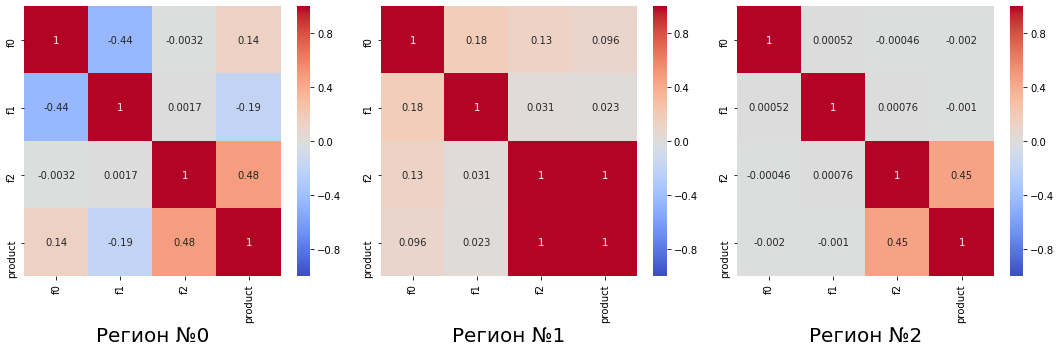

In [17]:
correlation(data, headers=['Регион №0','Регион №1','Регион №2'], figsize=(15,5))

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Молодец, что заметил эту корреляцию. Она и в правду странная.

</div>


Избавимся от id, как от признака без ML-нагрузки и выделим features и target:

In [18]:
feat = []
targ = []
for i in range(0, len(data)):
    feat.append(data[i][['f0','f1','f2']])
    targ.append(data[i]['product'])

Разделим и отмасштабируем выборки (с shuffle в train_test_split и без него): 

In [19]:
feat_targ_s = []
feat_targ_u = []
for i in range(0, len(feat)):
    feat_targ_s.append(split_and_scale(feat[i], targ[i], shuffle=True)) 
    feat_targ_u.append(split_and_scale(feat[i], targ[i], shuffle=False))
    

In [20]:
display_side_by_side(
        feat_targ_s[0][0].head(8),
        feat_targ_s[1][0].head(8),
        feat_targ_s[2][0].head(8),
        titles = [f'Регион №{0}: train feat/sc/sh',f'Регион №{1}: train feat/sc/sh',f'Регион №{2}: train feat/sc/sh']
    )

,f0,f1,f2
0,-0.544093,1.389958,-0.096387
1,1.456281,-0.481508,1.207188
2,0.261047,0.824527,-0.206212
3,-1.836133,0.009439,-0.149023
4,-1.298370,0.987084,1.270756
5,-0.657833,1.807424,1.705968
6,-1.461661,1.019813,0.512298
7,0.704160,0.741198,-0.216492
,f0,f1,f2
0,1.292355,0.600674,-1.078646


Для контроля, посмотрим еще раз:

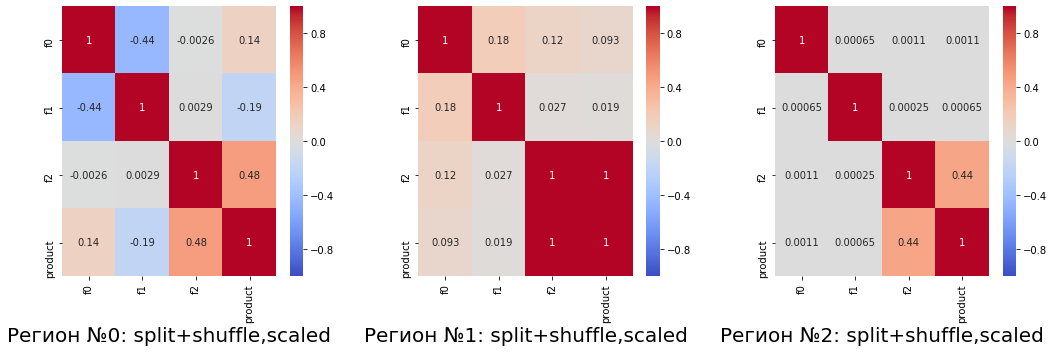

In [21]:
correlation([
                feat_targ_s[0][0].join(feat_targ_s[0][2]),
                feat_targ_s[1][0].join(feat_targ_s[1][2]),
                feat_targ_s[2][0].join(feat_targ_s[2][2])
            ],
        headers=['Регион №0: split+shuffle,scaled','Регион №1: split+shuffle,scaled','Регион №2: split+shuffle,scaled'], 
        figsize=(15,5))

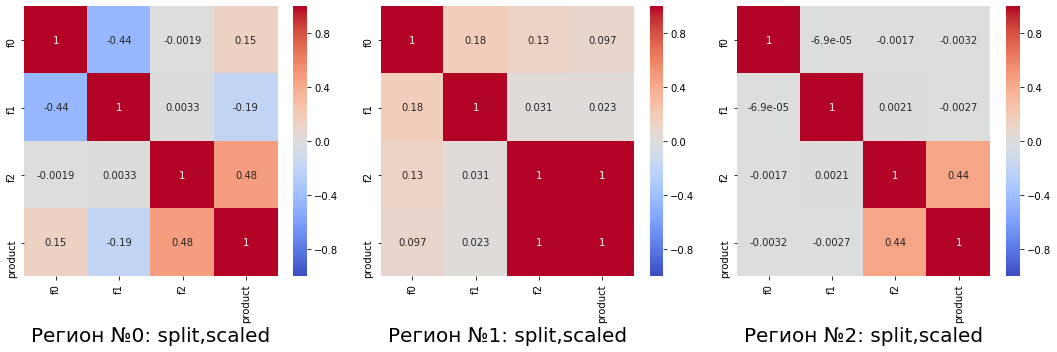

In [22]:
correlation([
                feat_targ_u[0][0].join(feat_targ_u[0][2]),
                feat_targ_u[1][0].join(feat_targ_u[1][2]),
                feat_targ_u[2][0].join(feat_targ_u[2][2])
            ],
        headers=['Регион №0: split,scaled','Регион №1: split,scaled','Регион №2: split,scaled'], 
        figsize=(15,5))

От перестановки слагаемых сумма практически не меняется, но shuffled мне чуть более симпатична, ее и будем использовать

In [23]:
feat_targ = feat_targ_s.copy()

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Шаг выполнен отлично.

</div>


## Обучение и проверка модели

Найдем лучшие параметры и обучим соответствующие модели для регионов:

In [24]:
estimators = []
for i in range(0, len(feat_targ)):
    gscv = GridSearchCV(
        LinearRegression(),
        {
            'fit_intercept': [True, False],
            'normalize': [True, False],
            'copy_X': [True]
        }, 
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=0,
        return_train_score=True,
        refit=True)
    gscv.fit(feat_targ[i][0],feat_targ[i][2])
    estimators.append([gscv.best_estimator_, (gscv.best_score_  * (-1)) ** 0.5])

Получим предсказания и ошибки для каждого региона:

In [25]:
pred = []
for i in range(0, len(estimators)):
    pred_valid = estimators[i][0].predict(feat_targ[i][1])
    pred_rmse = mean_squared_error(feat_targ[i][3], pred_valid)
    pred.append([pd.Series(pred_valid), pred_rmse ** 0.5])

Визуализируем итог:

In [26]:
columns=['Предсказанный средний запас', 'RMSE', 'CV-RMSE']
visual = pd.DataFrame(columns=columns)
for i in range(0, len(pred)):
    row = pd.Series(
        {
            f'{columns[0]}': pred[i][0].mean(), 
            f'{columns[1]}': pred[i][1], 
            f'{columns[2]}': estimators[i][1]
        }, name=f'Регион №{i}')
    visual = visual.append(row)
visual
        

,Предсказанный средний запас,RMSE,CV-RMSE
Регион №0,92.527983,37.485863,37.763232
Регион №1,74.922209,0.885602,0.887422
Регион №2,94.871776,40.155926,40.023305


Как и ожидалось, мы практически безошибочно предсказываем в регионе №1, где межу target и F2 есть зависимость; ошибиться в этом случае почти невозможно.

Но сказать что-то определенное по этим данным в части бизнеса сейчас нельзя.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Здесь тоже все корректно.

</div>


## Подготовка к расчёту прибыли

Немного статики (это ужасно, но "так тоже было можно"):

In [27]:
DRILLING_BUDGET = 10e9 # общий бюджет на все скважины
MAX_WELLS = 200 # число скважин
COST_PER_WELL = DRILLING_BUDGET / MAX_WELLS # средняя себестоимость скважины, нефтяники плачут
RUB_YEILD_PER_KILOBARREL = 45e4 # доход с 1 тыс. баррелей
WELL_BREAKEVEN_POINT_KILOBARRELS = COST_PER_WELL / RUB_YEILD_PER_KILOBARREL # точка безубыточности для отдельной скважины
SUBSAMPLE_SIZE = 500
BOOTSTRAP_COUNT = 1000
CONFIDENCE_INTERVAL = 0.95

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Молодец, что записываешь имена констрант заглавными буквами. Также можно использовать `_` как разделитель для длинных чисел:
    
>`PRICE = 1_000_000_000`

</div>


In [28]:
print('Усредненная точка безубыточности (необходимый выход в расчете на 1 скважину): ',WELL_BREAKEVEN_POINT_KILOBARRELS, 'тыс. бареллей')

Усредненная точка безубыточности (необходимый выход в расчете на 1 скважину):  111.11111111111111 тыс. бареллей


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Порог, при котором разработка будет безубыточной, определен верно.

</div>


А что по средним на фактических данных? Кто знает, может и регион №1 суммет выйти на "среднюю безубыточность"

In [29]:
display_side_by_side(
    data[0][['product']].describe().loc[['mean','std']],
    data[1][['product']].describe().loc[['mean','std']],
    data[2][['product']].describe().loc[['mean','std']],
    titles = [f'Регион №0', f'Регион №1', f'Регион №2']
)

,product
mean,92.500925
std,44.287947
,product
mean,75.001362
std,42.861205
,product
mean,95.000950
std,44.749136


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Не выйдет :) Без модели не справимся.

</div>


## Расчёт прибыли и рисков 

Предположим, мы будем расходовать весь бюджет на регион (что конечно безумно, но ...), т.е. в любом случае - пробурим 200 скважин. Тогда:

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

Вдруг мы в идеальном мире :) Или в стоимость бурения уже заложены, так сказать, издержки 😂

</div>


In [30]:
def calculate_profit(data: pd.Series, wells: int) -> float:
    return data\
        .sort_values(ascending=False)\
        .head(wells)\
        .sum() * RUB_YEILD_PER_KILOBARREL - wells * COST_PER_WELL

In [31]:
for i in range(0, len(pred)):
    print(f'Общая прогнозируемся прибыль в регионе №{i}:', pretty_billions(calculate_profit(pred[i][0], MAX_WELLS)))
    

Общая прогнозируемся прибыль в регионе №0: 3.92 млрд.руб.
Общая прогнозируемся прибыль в регионе №1: 2.48 млрд.руб.
Общая прогнозируемся прибыль в регионе №2: 3.33 млрд.руб.


<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера</b>

На мой взгляд, было бы нагляднее привести данные в млрд.

</div>


<div class="alert alert-info">
<b>Комментарий студента:</b>

pretty_billions - действительно, и нагляднее, и приятнее :)</div>

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера (v2)</b>

Классное название функции 😂

</div>


Покомбинируем субвыборки (по 500, согласно условиям) из pred через bootstrap и посмотрим волатильность оценок прибыли в регионах:

In [32]:
state = np.random.RandomState(GLOBAL_RANDOM_STATE)
def bootstrap(data: pd.Series, subsample_size: int) -> pd.Series:
    values = []
    for i in range(0, BOOTSTRAP_COUNT):
        subsamples = data.sample(n=subsample_size, replace=True, random_state=state)   
        values.append(calculate_profit(subsamples, MAX_WELLS))
    res = pd.Series(values)
    return res

In [33]:
profits = []
for i in range(0, len(pred)):
    profits.append(bootstrap(pred[i][0], SUBSAMPLE_SIZE))

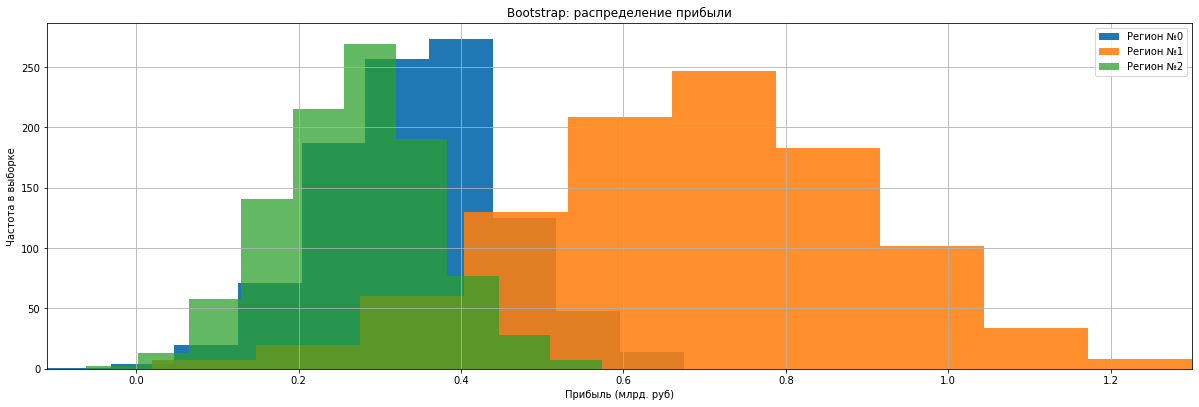

In [34]:
hist(
    onecolumn_frames_list = [
        pd.DataFrame({'Регион №0': profits[0].apply(lambda x: pretty_billions_f(x))}),
        pd.DataFrame({'Регион №1': profits[1].apply(lambda x: pretty_billions_f(x))}),
        pd.DataFrame({'Регион №2': profits[2].apply(lambda x: pretty_billions_f(x))}),
    ],
    xlab='Прибыль (млрд. руб)',
    ylab='Частота в выборке',
    title='Bootstrap: распределение прибыли',
    fontsize=18,
    figsize=(17,6)
)

Весьма неожиданно, надо признать, но Регион №1 выбивается в явные лидеры. Да и ожидаемая прибыль сильно упала, по сравнению со единственным сценарием работы на лучших (по результатам разведки) скважинах.

In [35]:
columns=['Нижняя граница д.и.','Средняя выручка', 'STD средней выручки','Верхняя граница д.и.','Риск убытков (через 0)','Риск убытков (избыточно сложно)']
visual = pd.DataFrame(columns=columns)
for i in range(0, len(pred)):
    profits_sorted = profits[i].sort_values();
    loss_value = profits_sorted[profits_sorted <= 0].max()
    loss_proba_1 = 0 if(pd.isna(loss_value)) else stats.percentileofscore(profits[i],loss_value)
    loss_proba_2 = stats.percentileofscore(profits[i],0)
    row = pd.Series(
        {
            f'{columns[0]}': pretty_billions(profits[i].quantile((1-CONFIDENCE_INTERVAL)/2)), 
            f'{columns[1]}': pretty_billions(profits[i].mean()), 
            f'{columns[2]}': pretty_billions(profits[i].std()), 
            f'{columns[3]}': pretty_billions(profits[i].quantile((1+CONFIDENCE_INTERVAL)/2)), 
            f'{columns[4]}': f'{loss_proba_1}%',
            f'{columns[5]}': f'{loss_proba_2}%'
        }, name=f'Регион №{i}')
    visual = visual.append(row)
visual

,Нижняя граница д.и.,Средняя выручка,STD средней выручки,Верхняя граница д.и.,Риск убытков (через 0),Риск убытков (избыточно сложно)
Регион №0,0.125 млрд.руб.,0.346 млрд.руб.,0.112 млрд.руб.,0.554 млрд.руб.,0.2%,0.2%
Регион №1,0.271 млрд.руб.,0.694 млрд.руб.,0.209 млрд.руб.,1.09 млрд.руб.,0%,0.0%
Регион №2,0.0853 млрд.руб.,0.27 млрд.руб.,0.0956 млрд.руб.,0.463 млрд.руб.,0.2%,0.2%


<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера</b>

<s>Я не совсем понял вычисление рисков. Мне кажется, не совсем верный подход. Для последнего региона в loss_value сейчас лежит такое значение (вывел ниже). Но ведь убытки это когда меньше нуля. И надо в percentileofscore положить не loss_value, а ноль. Пожалуйста, оставь свой комментарий, если я неправильно понял идею.

</div>


In [36]:
loss_value

-21376341.1939888

<div class="alert alert-info">
<b>Комментарий студента:</b>

В принципе, ты прав: можно указать 0, это "просто и элегантно" - функция сама рассчитает нужное значение (например, усреднением, ведь мы же понимаем, что выборка дискретна). 
Я делаю чуть избыточный код, говоря: отбери все значения, где нет прибыли (=0) или есть убыток (<0) и возьми из них максимум. Это, в частности,
может быть и не 0 (мне трудно вообразить, что кто-то специально подгонял датасет, чтобы при расчете прибыли хотя бы на одной из 1000 бутстреп-выборок обязательно получался 0).
Т.е. я "помогаю функции с точным значением из выборки, для которого мне нужен перцентиль", что, как я уже и сказал избыточно. **Но на конечный результат это не повлияет, что и видно из таблицы**</div>

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера (v2)</b>

Прошу прощения, был не прав с возвратом работы из-за этого. Сейчас логику понял :)

</div>


<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера</b>

Также можно вычислить среднюю выручку.

</div>


И (на удивление) разумным выбором становится Регион №1: даже если мы будем произвольно (то есть вообще никак не ориентируясь на features) бурить скважины, то
    с  вероятностью 95% мы заработаем больше денег, чем в других регионах и при этом без риска получить убыток.

Вывод: хочешь прибыли - занимайся нефтью, а не ML (ok, ML в нефтянке - как компромисс) 

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера</b>

С выбором региона согласен. Хороший, цельный проект с понятным кодом и грамотными выводами, молодец.

ML в металлургии тоже неплохо, кстати. Северсталь, Норникель, еще какая-то крупная металл-компания постоянно людей набирают :)

</div>


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован